# Elo's Method
    - Matt Robinson, Yale Undergraduate Sports Analytics Group

This notebook is one of several notebooks exploring ratings systems often used in sports. All of the notebooks can be found in this [repo](https://github.com/mc-robinson/Ratings_Methods).

Specifically, this notebook attempts to both explain and implement the popular Elo ratings model created by Arpad Elo, who was both a physicist and an excellent chess player. Although originally created as a way to rank chess players, the Elo method has been used to rank almost anything from football teams to a more controversial example detailed below:

Mark: "I need the algorithm used to rank chess players."

Eduardo: "Are you okay?"

Mark: "We're ranking girls."

Eduardo: "You mean other students?"

Mark: "Yeah"

Eduardo: "Do you think this is such a good idea?"

Mark: "I need the algorithm - I need the algorithm."

<img src="http://cdn.collider.com/wp-content/uploads/the_social_network_movie_image_andrew_garfield_01.jpg" width="400" height="400" />

from *The Social Network (2010)*

Whether Mark Zuckerberg really asked Eduardo Savarin for the Elo algorithm, I don't know. However, I do know that the formula Eduardo writes on the board is slightly incorrect. We'll get to that in a bit...

## The Basic Idea:

Elo's original idea was pretty simple: each player's performance essentially follows a normal distribution centered at some mean strength $u$, which we consider that player's Elo rating. So, when an average chess player (rating = 1500) competes in a match, the distribution of his performance looks something like this:

(Note: the following graphs are used mostly for illustrative purposes. The exact parameters and shapes of the distributions should not be taken too seriously)

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

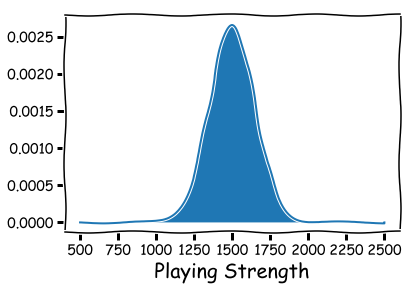

In [31]:
with plt.xkcd():
    # Plot between 500 and 2500 with .1 steps.
    x_axis = np.arange(500, 2500, 0.1)
    # Mean = 1500, SD = 200.
    plt.plot(x_axis, norm.pdf(x_axis,1500,150))
    plt.fill_between(x_axis, norm.pdf(x_axis,1500,150))
    plt.xlabel("Playing Strength",fontsize=20)

On a given day, the average player's stength will probably not be exactly 1500. Some days they'll do better, some days worse. The height of the strength in the above distribution roughly shows the chance that a player will perform at the given strength. It makes sense that a player with an Elo rating of 1500 is more likely to play with a strength of 1600 than 2000.

[Mark Glickman](https://statistics.fas.harvard.edu/people/mark-e-glickman) gives a nice analogy for understanding the method in his excellent [overview of chess ratings methods](http://www.glicko.net/research/acjpaper.pdf):
> 
Suppose that every player brings a box containing many numbered slips of paper when sitting down to a chess game. Each number represents the player's "strength distribution." Instead of actually playing a chess game, each player reaches into the box and pulls out a single piece of paper at random, and the one containing the high number wins. In effect, this model for chess performance says that each player has the ability to play at a range of different strengths, but displays only one of these levels of ability during the game. Naturally, this procedure favors the person who carries a box that contains generally higher numbers, but of course this does not mean an automatic victory. This is analogous to chess where a better player usually wins, but not always.

Now, let's see what it looks like when a weaker "player A" (rating = 1350) plays a stronger "player B" (rating = 1650):


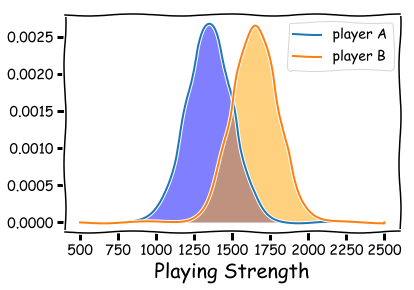

In [34]:
with plt.xkcd():
    x_axis = np.arange(500, 2500, 0.1)
    plt.plot(x_axis, norm.pdf(x_axis,1350,150),label="player A")
    plt.fill_between(x_axis, norm.pdf(x_axis,1350,150), facecolor='blue', alpha=0.5)
    plt.plot(x_axis, norm.pdf(x_axis,1650,150),label="player B")
    plt.fill_between(x_axis, norm.pdf(x_axis,1650,150), facecolor='orange', alpha=0.5)
    plt.legend(loc="best")
    plt.xlabel("Playing Strength",fontsize=20)

Obviously, in most matches between these two opponenets, player B (who has the higher rating) will display a greater strength and win. However, we see that the two distributions still overlap quite a bit. What we really want to see is when the worse player A's strength is higher than that of the better player B's strength:

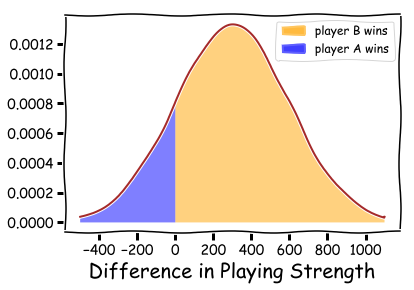

In [35]:
with plt.xkcd():
    x_axis = np.arange(-500, 1100, 0.1)
    plt.plot(x_axis, norm.pdf(x_axis,300,300), color='brown')
    # plt.fill_between(x_axis, norm.pdf(x_axis,300,300), facecolor='brown', alpha=0.5)
    plt.fill_between(x_axis, norm.pdf(x_axis,300,300), where=x_axis >0, facecolor='orange', alpha=0.5, label="player B wins")
    plt.fill_between(x_axis, norm.pdf(x_axis,300,300), where=x_axis <0, facecolor='blue', alpha=0.5, label= "player A wins")
    plt.legend(loc="upper right", fontsize=12)
    plt.xlabel("Difference in Playing Strength",fontsize=20)

When the difference in playing strengh is greater than zero, player B "drew" a higher value from his distribution than player A. Player B's chance of winning is thus equal to the "orange" fraction of the area under the curve. As can be seen in this graph, the better player B wins most of the time. However, when player B's rating minus player A's rating is less than zero ("blue" part of graph), then the worse player A wins. 

You may have noticed that the above example used one pretty big assumption: the spread of each player's performance about his or her mean performance is exactly the same! This may seem suspect to you, but Elo made this assumption so that we only need to keep track of a player's average strength (Elo rating) and nothing else. This makes the system pretty simple to use.

### How to calculate an Elo rating

As explained above, a player's Elo rating is an estimate of his or her average strength. Obviously, this is probably not his or her "true average strength," and a player's strength is also not constant over time. Thus, Elo came up with a self correcting system for a player's rating to adjust based on that player's results. 

Elo's adjustment rule for the ratings is:

$$
r_{new} = r_{old} + K(S-S_{exp}),
$$

where $r_{new}$ is the player's updated rating after the game, $r_{old}$ is the player's rating before the game, $S$ is the player's score in the game, $S_{exp}$ was the player's expected score in the game, and $K$ is a constant determining how much this game should affect the player's old rating.

When player A competes against player B in a chess match, players A's score aginast player B, $S_{AB}$, is as follows:

$$
S_{AB} = \begin{cases}1 & \text{if $a$ beats $b$}\\1/2 & \text{if $a$ and $b$ draw}\\0 & \text{if $a$ loses to $b$}\end{cases}
$$

But now we also need to know player A's expected score $E_{AB}=S_{exp}$ when he or she play's player B. An assumption of the model is that $E_{AB}$ follows a base-ten logistic function of the difference in ratings:

$$
E_{AB} = \frac{1}{1+10^{{-(r_A - r_B)}/{400}}},
$$

where $r_A$ and $r_B$ are the ratings of players A and B, respectively. This is also the equation Eduardo should have written on the window in *The Social Network*, but he forgot to put the difference in ratings in the exponent. 

Let's see what this function looks like:

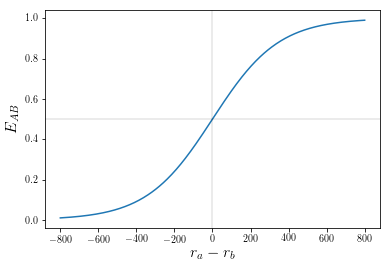

In [57]:
x = np.linspace(-800, 800, 400)
y = 1/(1+(10**(-x/400)))
plt.plot(x,y)
plt.axvline(x=0, color='k', linestyle='-',alpha=0.1)
plt.axhline(y=0.5, color='k', linestyle='-',alpha=0.1)
plt.xlabel(r'$r_a - r_b$', fontsize = 16)
plt.ylabel(r'$E_{AB}$', fontsize=16)
plt.show()

This sigmoidal curve is roughly what we should expect. When the difference in ratings is $0$, each competitor has an equal chance of winning. Furthermore, when player A is rated 400 points higher than player B, they have 10X the chance of winning as player B does.

To further get a feel for this equation, let's look at the example matchup from before between player A (rating = 1350) and player B (rating = 1650).

First, lets calculate the expected score of A, $E_{AB}$

$$
E_{AB} = \frac{1}{1+10^{{-(1350 - 1650)}/{400}}} = 0.151
$$

And, let's also calculate the expected score of B, $E_{BA}$

$$
E_{BA} = \frac{1}{1+10^{{-(1650 - 1350)}/{400}}} = 0.849
$$

As you can see, $E_{AB}$ and $E_{BA}$ add up to 1. This is a nice fact that will hold true in general. Another interpretation of $E_{AB}$ is the win probability for player A in the competition against player B.

Let's go back to player A's expected score, $E_{AB}=0.151$. This means that player A is expected to beat player B at  most 15.1% of the time (likely less if there will be draws). If player A wins this matchup, his score $S_{AB}$ is 1, thus player A has outperformed his expected performance and should likely have a higher rating. His rating will be updated according to the update rule we specificed above:

$$
r_{A,new} = r_{A,old} + K(S-S_{exp}) = 1350 + K(1-0.151) = 1350 + K(0.849),
$$

where $K$ is often specific to the sport. 

Player B, on the other hand, has performed worse than expected. Thus, it is expected that player B's rating is higher than his or her true strengh and thus player B's rating should be decreased:

$$
r_{B,new} = r_{B,old} + K(S-S_{exp}) = 1350 + K(0-0.849) = 1350 - K(0.849),
$$

You can easily see that player B's rating decreases by exactly the same amount player A's rating increases.


Now let's imagine the opposite, more likely result in which the ostensibly stronger player B beats player A. The update equations are now as follows:

$$
r_{A,new} = r_{A,old} + K(S-S_{exp}) = 1350 + K(0-0.151) = 1350 - K(0.151),
$$
$$
r_{B,new} = r_{B,old} + K(S-S_{exp}) = 1350 + K(1-0.849) = 1350 + K(0.151),
$$

This is an intersting result: the ratings change less significantly when the less unexpected result occurs. That is, the ratings do not change much when a very strong team beats a very weak team, but they change a lot when a very weak team beats a very strong team. 

When we think about sports, this is usually how we want ratings to work. When Stanford beats a much weaker Rice, Stanford's rating should not increase by much. However, if Stanford loses to Rice, Stanford's rating should plummet, and Rice should get a big bump in the ratings. As for Rice, their rating should definitely increase by more points if they beat Stanford than if they beat Charlotte. Elo nicely captures all of these desired features.

An interesting way to think about this is like a pot, where both teams put in a share of their ratings. And the higher rated player always puts a larger stake in the pot. In this case, the better player B puts in 0.849 of the pot and and the weaker player A puts in 0.151 of the pot. Whoever wins gets to take the whole pot, thus their rating increases by the losing team's ante. If the two teams tie, then they split the pot. 

#### The K-factor ####

Up to now, I have largely ignored the attenuation factor $K$ in the update equations. This was partly because $K$ is highly dependent on what we are using Elo to rank. $K$ basically corresponds to how much we want the new, more recent results to affect the old ratings. In chess, one typically sets $K=32$, but this may change based on how many games one has played. The goal is to have a $K$-factor that sufficiently tracks changes in team strength without having the ratings jump around too much.

Over at [fivethirtyeight](https://fivethirtyeight.com), they use $K=20$ for NFL football and also provide some nice [notes on their methodology](https://fivethirtyeight.com/datalab/introducing-nfl-elo-ratings/) in general. 

#### Correcting a slight lie ####

So I started this whole discussion talking about how Elo was based on the strength following a normal distribution. This was indeed Elo's original assumption, but others have found that using the *Bradley-Terry model* is a bit more accurate and easier to work with. In Bradley-Terry, it is assumed that a player's strength distribution follows an *extreme value distribution*, which looks like this (from [Glickman's article](http://www.glicko.net/research/acjpaper.pdf)):

<img src="http://github.com/mc-robinson/Ratings_Methods/blob/master/pictures/extreme_value_dist.png?raw=true", width="400" height="400" />

As can be seen from the distribution, Bradley-Terry assumes that a player is more likely to play above his true rating than below his true rating.

When two player's play each other, we again take the difference between the two distributions. Except now, the resulting distribution of strength differences is a *logistic distribution*, which is why we used a logistic function to estimate expected scores. The distribution iteslf looks like this (again, from [Glickman's article](http://www.glicko.net/research/acjpaper.pdf)):

<img src="http://github.com/mc-robinson/Ratings_Methods/blob/master/pictures/logistic_dist.png?raw=true", width="200" height="400" />

This actually looks really similar to the normal distribution we used before. According to Glickman, it's really not a big deal whether you use the normal or logistic distribution for differences in strengths. The Bradley-Terry assumption is just a bit easier to work with.

## Implementation



In order to work through the implementation of this method and understand how it works, I'm going to use an extremely simplified example. Let's imagine the Ivy league is instead the IV league and consists of only four teams who each play each other once: Harvard, Princeton, Yale, and Columbia.

Here are the results from the 2016 IV season that I scraped from the NCAA stats website:

In [81]:
IV_df = pd.read_csv('IV_league_2016.csv')
IV_df

,year,month,day,team,opponent,location,team_score,opponent_score
0,2016,10,1,Columbia,Princeton,1,13,48
1,2016,10,22,Harvard,Princeton,-1,23,20
2,2016,10,28,Columbia,Yale,1,23,31
3,2016,11,5,Columbia,Harvard,-1,21,28
4,2016,11,12,Princeton,Yale,-1,31,3
5,2016,11,19,Harvard,Yale,1,14,21


You will notice that the games are arranged in order of date played, this is very important for calculating Elo ratings.

As of right now, all the Elo method cares about is wins and losses, so let's go ahead an find the ratings. To start, we need to give all teams an initial ranking. It is customary to start each team with a rating of 1500, which is set as the average rating.

I'll begin by making a dictionary of the teams and their ratings:

In [115]:
ratings_dict = {}
for index, row in IV_df.iterrows():
    ratings_dict[row['team']] = 1500
    # also go through opponent column in case any team only in that column
    ratings_dict[row['opponent']] = 1500

In [116]:
ratings_dict

{'Columbia': 1500, 'Harvard': 1500, 'Princeton': 1500, 'Yale': 1500}

Now let's go through and apply the Elo algorithm. I will start by constructing the update function with $k=20$:

(Note that there are no ties, so I am not going to worry about that for now)

In [117]:
# function to update elo ratings based on result
def update_ratings(winner_rating, loser_rating):
    
    # initialize k_factor
    k = 20
    
    # get expected scores for each team
    E_winner = 1/(1+(10 ** (-(winner_rating-loser_rating)/400)))
    E_loser = 1/(1+(10 ** (-(loser_rating-winner_rating)/400)))
    
    # Initialize actual scores
    S_winner = 1
    S_loser = 0
    
    # update elo ratings
    new_winner_rating = winner_rating + (k * (S_winner - E_winner))
    new_loser_rating = loser_rating + (k * (S_loser - E_loser))
    
    return [new_winner_rating, new_loser_rating]

Now we just need to iterate over the games and apply the algorithm:

In [118]:
for index, row in IV_df.iterrows():
    
    team = row['team']
    team_score = row['team_score']
    opponent = row['opponent']
    opponent_score = row['opponent_score']
    
    # check who won
    if team_score > opponent_score:
        winner = team
        loser = opponent
    else:
        winner = opponent
        loser = team
        
    # get current ratings
    winner_rating = ratings_dict[winner]
    loser_rating = ratings_dict[loser]
    
    # update the ratings
    ratings_dict[winner] = update_ratings(winner_rating, loser_rating)[0]
    ratings_dict[loser] = update_ratings(winner_rating, loser_rating)[1]

In [119]:
ratings_dict

{'Columbia': 1471.1490735237644,
 'Harvard': 1508.851348024768,
 'Princeton': 1510.0,
 'Yale': 1509.9995784514676}

Obviously, not many games have been played in this four team season, so the ratings really don't mean much. Furthermore, we have not included any information about home-field advantage or score differential, thus giving the system even less information to work on. This can be seen as both an advantage and disadvantage of the current Elo implementation. 

## To be continued:

There are some interesting extensions to Elo that incorporate home-field advantage, margin of victory, and data from past seasons. I hope to explain how to implement that stuff eventually once I have some more free time... 

For now, [fivethirtyeight](http://fivethirtyeight.com/) explains their methodology, which includes these features, quite nicely [here](https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/) and [here](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/)

## Is Elo a good rating system?

There are a lot of opinions on this one. Let's first start with the thoughts of John Beasley, who wrote this in his book [*The Mathematics of Games*](https://www.amazon.com/Mathematics-Games-Dover-Books/dp/0486449769):

> 
Chess enthusiasts may be surprised that the name of Elo has not figured 
more prominently in this discussion, since the Elo rating system has been in use 
internationally since 1970.  However, Elo's work as described in his book (Batsford 1978) is 
open to serious criticism.  His statistical testing is unsatisfactory to the 
point of being meaningless; he calculates standard deviations without allowing 
for draws, he does not always appear to allow for the extent to which his tests 
have contributed to the ratings which they purport to be testing, and he fails to 
make the important distinction between proving a proposition true and merely 
failing to prove it false.  In particular, an analysis of 4795 games from 
Milwaukee Open tournaments, which he represents as demonstrating the normal 
distribution function to be the appropriate expectation function for chess, is 
actually no more than an incorrect analysis of the variation within his data. He 
also appears not to realize that changes in the overall strength of a pool cannot 
be detected, and that his 'deflation control', which claims to stabilize the 
implied reference level, is a delusion.  Administrators of other sports (for 
example tennis) currently publish only rankings.  The limitations of those are 
obvious, but at least they do not encourage illusory comparisons between today's 
champions with those of the past.

Obviously, Beasley was not a fan. But, to redeem Elo a bit, here is the opinion of Mark Glickman, who knows chess ratings probably better than anyone:

> 
Elo's framework is quite appealing: players have ratings prior to a tournament which, in theory, predict their performances, game outcomes are observed, and players' ratings are adjusted to account for the differences between the observed results and the pre-event expectations. This process is then repreated for the next event. While much of Elo’s development can be criticized for its lack of reliance on established statistical principles, he successfully implemented a system that appears to track players’ performances with reasonable accuracy.

In terms of sports, Elo is used all over the place and [fivethirtyeight](http://fivethirtyeight.com/) uses it for pretty much everything. Additionally, Jeff Sagarin used Elo for a long time for his BCS rankings and had this to say:

>>
If I were czar of the NCAA, I’d use Elo. It’s not like I’m suggesting affirmative action for the small conferences. But the way the RPI is set up, it’s like telling a kid in a ghetto high school, 'No matter what you get on your SATs, you can’t go to college.'

Then again, he also noted that it was not as good a predictor of upcoming games as his pure points model, which does take into account margin of victory. So, lots of things to consider. But, overall, Elo's method is relatively simple and gets some reliable results.

## Main References

* *[Who’s # 1?: The Science of Rating and Ranking](https://www.amazon.com/Whos-1-Science-Rating-Ranking/dp/069116231X)* by Amy Langville and Carl Meyer
* [A Comprehensive Guide to Chess Ratings](http://www.glicko.net/research/acjpaper.pdf) by Mark Glickman